In [ ]:
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np

# Material parameters
RHO = 8100
C44 = 82.4e9 

# Define domain
LENGTH = 10.0 *1e-3  # length
N = 200
domain = mesh.create_interval(MPI.COMM_WORLD, N, [0.0, LENGTH])



In [ ]:
# linear strain tensor 
def epsilon_1d(u):
    return ufl.grad(u)

def sigma_1d(u):
    return C44 * epsilon_1d(u)
    
def epsilon(u):
    return ufl.sym(ufl.grad(u))  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)



# static C 
def solver(C, f, V, u_D=None, bdr_dofs=None):
    # Weak form of Poisson equation
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)


    a = ufl.dot(epsilon_1d(u), C * epsilon_1d(v)) * ufl.dx
    L = f * v * ufl.dx

    if u_D:
        uD = fem.Function(V)
        uD.interpolate(u_D)
        bc = fem.dirichletbc(uD, bdr_dofs)
        problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    else:
        
        problem = LinearProblem(a, L, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

    uh = problem.solve()
    
    return uh








def boundary_dofs(domain, V):
    topo_dim = domain.topology.dim
    facet_dim = topo_dim - 1
    domain.topology.create_connectivity(facet_dim, topo_dim)
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    boundary_dofs = fem.locate_dofs_topological(V, facet_dim, boundary_facets)
    return boundary_dofs

def u_D(x):
    return x[0]**2 + 1



In [ ]:
# Material parameters
RHO = 8100
C44 = 82.4e9 
# Define domain
LENGTH = 10.0 *1e-3  # length
N = 200
domain = mesh.create_interval(MPI.COMM_WORLD, N, [0.0, LENGTH])
n = ufl.FacetNormal(domain)

# Define function space
V = fem.functionspace(domain, ("Lagrange", 1))
# constant C
C = fem.Constant(domain, default_scalar_type(C44))
f = fem.Constant(domain, default_scalar_type(-2*C44))


# # # variable C
# C = fem.Function(V)
# f = fem.Function(V)

# C.interpolate(lambda x: x[0]*2)
# f.interpolate(lambda x: x[0]/2)


uh = solver(C, f, V, u_D, boundary_dofs(domain, V))
# uh = solver(C, f, V)
uh.x.array

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


# dof_coords = V.tabulate_dof_coordinates()
# x_arr = dof_coords[:,0]
# plt.plot(x_arr, x_arr**2+1)

n_dofs = V.tabulate_dof_coordinates().shape[0]
plt.plot(x_arr, uh.x.array)
plt.show()

In [ ]:
# import pyvista

# from dolfinx import plot
# # pyvista.set_jupyter_backend("html")

# domain.topology.create_connectivity(topo_dim, topo_dim)
# topology, cell_types, geometry = plot.vtk_mesh(domain, topo_dim)
# grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
# plotter = pyvista.Plotter(notebook=True)
# plotter.add_mesh(grid, show_edges=True)
# plotter.show()


In [ ]:
# u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
# u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
# u_grid.point_data["u"] = uh.x.array.real
# u_grid.set_active_scalars("u")
# u_plotter = pyvista.Plotter()
# u_plotter.add_mesh(u_grid, show_edges=True)
# u_plotter.view_xy()
# u_plotter.show()

# warped = u_grid.warp_by_scalar()
# plotter2 = pyvista.Plotter()
# plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
# plotter2.show()

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem
import ufl
import numpy as np
from petsc4py import PETSc

# --- Material and domain ---
RHO = 8100.0
C44 = 82.4e9
LENGTH = 10e-3
N = 200
domain = mesh.create_interval(MPI.COMM_WORLD, N, [0.0, LENGTH])
V = fem.functionspace(domain, ("Lagrange", 1))

u = fem.Function(V, name="Displacement")


u_old = fem.Function(V)
v_old = fem.Function(V)
a_old = fem.Function(V)
a_new = fem.Function(V)
v_new = fem.Function(V)

beta_ = 0.25
beta = fem.Constant(domain, beta_)
gamma_ = 0.5
gamma = fem.Constant(domain, gamma_)
dt = fem.Constant(domain, 0.0)

a = 1 / beta / dt**2 * (u - u_old - dt * v_old) + a_old * (1 - 1 / 2 / beta)
a_expr = fem.Expression(a, V.element.interpolation_points())

v = v_old + dt * ((1 - gamma) * a_old + gamma * a)
v_expr = fem.Expression(v, V.element.interpolation_points())


bdry_dofs = boundary_dofs(domain, V)
u_bc = fem.Constant(domain, 0.0)

bcs = [fem.dirichletbc(u_bc, bdry_dofs, V)]

In [ ]:
u_ = ufl.TestFunction(V)
du = ufl.TrialFunction(V)

eta_M = fem.Constant(domain, 1e-4)
eta_K = fem.Constant(domain, 1e-4)



def mass(u, u_):
    return RHO * ufl.dot(u, u_) * ufl.dx


def stiffness(u, u_):
    return ufl.inner(sigma_1d(u), epsilon_1d(u_)) * ufl.dx


Residual = mass(a, u_)  + stiffness(u, u_) - ufl.dot(f, u_) * ufl.dx



In [ ]:
from dolfinx import mesh, fem, default_scalar_type
import ufl
import numpy as np
from mpi4py import MPI
from dolfinx.fem.petsc import assemble_vector, assemble_matrix

# --- Parameters ---
L = 0.1
nx = 1000
rho = 8100.0
C = 82.4e9
dt = 1e-8
T = 1e-5

t_arr = np.arange(0, T + dt, dt)
f_c = 1e6

fullwaveform_time_interval = 1


def ricker_wavelet(t, f0):
    """
    t : time array (seconds)
    f0: dominant frequency (Hz)
    """
    pi2 = (np.pi * f0)**2
    return (1 - 2*pi2*t**2) * np.exp(-pi2*t**2)



# --- Mesh and function space ---
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0, L])
V = fem.functionspace(domain, ("P", 1))

# --- Trial and test functions ---
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# --- Source term ---
f = fem.Constant(domain, 0.0)

# --- Bilinear and mass forms ---
a_mass = rho * u * v * ufl.dx
a_stiff = C * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx

M = assemble_matrix(fem.form(a_mass))
M.assemble()
K = assemble_matrix(fem.form(a_stiff))
K.assemble()

# # --- Apply Dirichlet BCs (fixed ends) ---
# u0 = fem.Constant(domain, 0.0)
# bdry_facets = mesh.locate_entities_boundary(
#     domain, 0,  # <-- boundary entities are 0D points
#     lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
# )
# bc = fem.dirichletbc(u0, fem.locate_dofs_topological(V, 0, bdry_facets), V)

def ricker_wavelet(t, f0, t0=None):
    """
    t  : time array (seconds)
    f0 : dominant frequency (Hz)
    t0 : time shift to move main peak away from t=0
    """
    if t0 is None:
        t0 = 1.0 / f0  # typical choice for time shift
    
    tau = t - t0  # shift the wavelet
    pi2 = (np.pi * f0)**2
    return (1 - 2*pi2*tau**2) * np.exp(-pi2*tau**2)

from petsc4py import PETSc

# Allocate PETSc vectors
u_n_vec   = PETSc.Vec().createSeq(V.dofmap.index_map.size_local)
u_nm1_vec = PETSc.Vec().createSeq(V.dofmap.index_map.size_local)
u_np1_vec = PETSc.Vec().createSeq(V.dofmap.index_map.size_local)
force_vec = PETSc.Vec().createSeq(V.dofmap.index_map.size_local)

# source loc 
src_id = 100
stf = ricker_wavelet(t_arr, f_c)*1e9

u_history = []


# Temporary vectors for arithmetic
tmp1 = u_n_vec.duplicate()
rhs  = u_n_vec.duplicate()

for i, t in enumerate(t_arr):

    arr = force_vec.getArray()
    arr[src_id] = stf[i]
    # store historical data
    if i % fullwaveform_time_interval == 0:
        u_history.append(u_np1_vec.getArray(readonly=True).copy())

    # rhs = 2M*u_n - M*u_nm1 - dt^2*K*u_n +  dt^2*force

    
    # 2M*u_n
    M.mult(u_n_vec, rhs)
    rhs.scale(2.0)
    
    # - M*u_n-1
    tmp = u_nm1_vec.duplicate(); M.mult(u_nm1_vec, tmp)
    rhs.axpy(-1.0, tmp)
    
    # -dt ^2*K*u_n
    K.mult(u_n_vec, tmp1)
    rhs.axpy(-dt**2, tmp1)
    
    # dt^2*force
    rhs.axpy(dt**2, force_vec)
    
    # Solve M * u_n+1 = rhs
    solver = PETSc.KSP().create()
    solver.setOperators(M)
    solver.setType("preonly")
    solver.getPC().setType("lu")
    solver.solve(rhs, u_np1_vec)

    print(u_np1_vec.getArray())
    # shift in time
    u_nm1_vec.copy(u_n_vec)
    u_n_vec.copy(u_np1_vec)




[-2.64720376e-67  5.29440752e-67 -1.85304263e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-3.15416645e-67  6.30833290e-67 -2.20791651e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-3.74991077e-67  7.49982153e-67 -2.62493754e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-4.44829804e-67  8.89659608e-67 -3.11380863e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-5.26503035e-67  1.05300607e-66 -3.68552124e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-6.21783618e-67  1.24356724e-66 -4.35248533e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-7.32666453e-67  1.46533291e-66 -5.12866517e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-8.61388560e-67  1.72277712e-66 -6.02971992e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-1.01044963e-66  2.02089927e-66 -7.07314744e-66 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-1.18263279e-66  2.36526557e-66 -8.27842951e-66 ...  0.00000000e+00
  0.

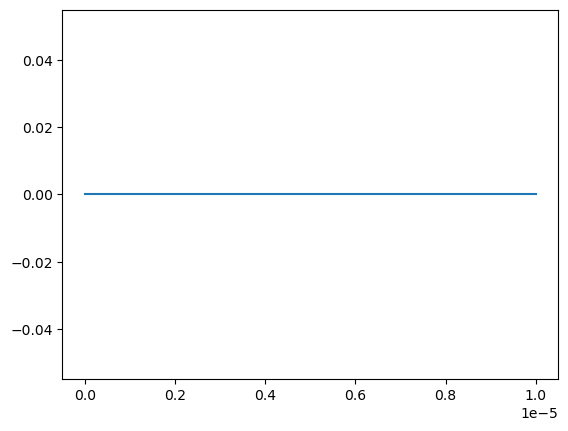

In [15]:
import matplotlib.pyplot as plt
rx_0 = [float(u[200]) for u in u_history]
plt.plot(t_arr, rx_0)

In [ ]:
from dolfinx import mesh, fem, default_scalar_type
import ufl
import numpy as np
from mpi4py import MPI
from dolfinx.fem.petsc import assemble_vector, assemble_matrix


# --- Parameters ---
L = 0.1
nx = 1000
RHO = 8100.0
C44 = 82.4e9
dt = 1e-7
T = 1e-4

t_arr = np.arange(0, T + dt, dt)
f_c = 1e6

fullwaveform_time_interval = 1


def ricker_wavelet(t, f0):
    """
    t : time array (seconds)
    f0: dominant frequency (Hz)
    """
    pi2 = (np.pi * f0)**2
    return (1 - 2*pi2*t**2) * np.exp(-pi2*t**2)



# --- Mesh and function space ---
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [0, L])
V = fem.functionspace(domain, ("P", 1))

u = fem.Function(V, name="Displacement")

dim = domain.topology.dim

# boundary condition
def boundary_dofs(domain, V):
    bdry_facets = mesh.locate_entities_boundary(
        domain, 0, lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], L)
    )
    return fem.locate_dofs_topological(V, 0, bdry_facets)

u0 = fem.Constant(domain, default_scalar_type(0.0))
bc = fem.dirichletbc(u0, boundary_dofs(domain, V), V) 
bcs = [bc]



# parameters 
rho = fem.Constant(domain, RHO)
c = fem.Constant(domain, C44)


# --- Source term ---
f = fem.Constant(domain, 0.0)

# Assume V is your function space
f = PETSc.Vec().createSeq(V.dofmap.index_map.size_local)

# Choose the physical location where you want the force
x0 = 0.5   # in 1D, for example
coords = V.tabulate_dof_coordinates().ravel()
dof_id = np.argmin(np.abs(coords - x0))  # closest DOF

# Set force value
force_value = 1e5
f.setValue(dof_id, force_value)
f.assemble()  # finalize vector


# Newmark time discretization
u_old = fem.Function(V)
v_old = fem.Function(V)
a_old = fem.Function(V)
a_new = fem.Function(V)
v_new = fem.Function(V)

beta_ = 0.25
beta = fem.Constant(domain, beta_)
gamma_ = 0.5
gamma = fem.Constant(domain, gamma_)
dt = fem.Constant(domain, 0.0)

a = 1 / beta / dt**2 * (u - u_old - dt * v_old) + a_old * (1 - 1 / 2 / beta)
a_expr = fem.Expression(a, V.element.interpolation_points())

v = v_old + dt * ((1 - gamma) * a_old + gamma * a)
v_expr = fem.Expression(v, V.element.interpolation_points())


# variational form
u_ = ufl.TestFunction(V)
du = ufl.TrialFunction(V)

# linear strain tensor 
def epsilon_1d(u):
    return ufl.grad(u)

def sigma_1d(u):
    return C44 * epsilon_1d(u)


def mass(u, u_):
    return rho * ufl.dot(u, u_) * ufl.dx

def stiffness(u, u_):
    return ufl.inner(sigma_1d(u), epsilon_1d(u_)) * ufl.dx


Residual = mass(a, u_) + stiffness(u, u_) - ufl.dot(f, u_) * ufl.dx

Residual_du = ufl.replace(Residual, {u: du})
a_form = ufl.lhs(Residual_du)
L_form = ufl.rhs(Residual_du)

problem = fem.petsc.LinearProblem(
    a_form, L_form, u=u, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)


vtk = io.VTKFile(domain.comm, "results/elastodynamics.pvd", "w")

t = 0
for i, dti in enumerate(np.diff(t_arr)):
    if i % fullwaveform_time_interval == 0:
        vtk.write_function(u, t)
        
    dt.value = dti
    t += dti
    f.value




ModuleNotFoundError: No module named 'dolfin'

In [28]:
f = fem.Constant(domain, (0.0,) * dim)
f.value

array([0.])

In [29]:
from ufl import PointSource


ImportError: cannot import name 'PointSource' from 'ufl' (/home/oliver/miniforge3/envs/fenicsx-env/lib/python3.13/site-packages/ufl/__init__.py)

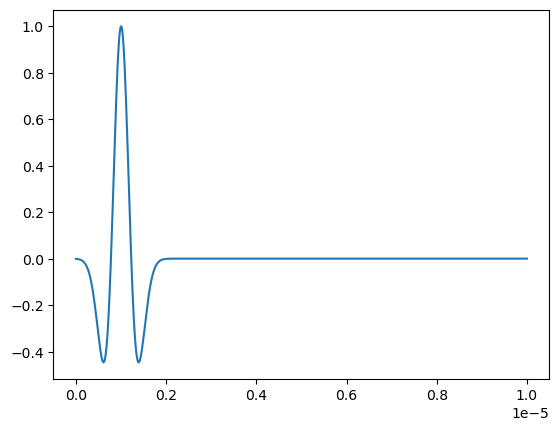

In [11]:

def ricker_wavelet(t, f0, t0=None):
    """
    t  : time array (seconds)
    f0 : dominant frequency (Hz)
    t0 : time shift to move main peak away from t=0
    """
    if t0 is None:
        t0 = 1.0 / f0  # typical choice for time shift
    
    tau = t - t0  # shift the wavelet
    pi2 = (np.pi * f0)**2
    return (1 - 2*pi2*tau**2) * np.exp(-pi2*tau**2)
import matplotlib.pyplot as plt
f_c = 1e6
stf = ricker_wavelet(t_arr, f_c)
plt.plot(t_arr, stf )

In [ ]:
print("Global size:", K.getSize())       # (rows, cols)
print("Local size:", K.getLocalSize())   # portion owned by this MPI process
